In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
from pathlib import Path
from data_loader.dataLoader import KaggleCSVLoader

from scipy.stats import gaussian_kde, norm

PROJECT_ROOT = Path().resolve()
sys.path.append(str(PROJECT_ROOT))

## Fetching Data

In [2]:
# Loading Kaggle Data
DATASET_NAME = "dhrubangtalukdar/fortune-500-companies-stock-data"

loader = KaggleCSVLoader(
    dataset_name=DATASET_NAME,
    raw_data_dir='data/raw'
)

stock_data = loader.run() # stock_data: dict[str, pd.DataFrame]

CVS files already exist. Skipping download.
Loading NVR.csv
Loading Halliburton.csv
Loading Altria_Group.csv
Loading Paccar.csv
Loading Constellation_Energy.csv
Loading Cintas.csv
Loading Warner_Bros_Discovery.csv
Loading EMCOR_Group.csv
Loading Northern_Trust.csv
Loading Gilead_Sciences.csv
Loading Mastercard.csv
Loading Thermo_Fisher_Scientific.csv
Loading Devon_Energy.csv
Loading United_Rentals.csv
Loading Thor_Industries.csv
Loading CBRE_Group.csv
Loading Genuine_Parts.csv
Loading Voya_Financial.csv
Loading Unum_Group.csv
Loading Carrier_Global.csv
Loading Fox.csv
Loading Corebridge_Financial.csv
Loading AutoZone.csv
Loading Huntington_Ingalls_Industries.csv
Loading Charter_Communications.csv
Loading Micron_Technology.csv
Loading Ross_Stores.csv
Loading Elevance_Health.csv
Loading Newmont.csv
Loading Lincoln_National.csv
Loading HCA_Healthcare.csv
Loading PepsiCo.csv
Loading Global_Payments.csv
Loading Alaska_Air_Group.csv
Loading Starbucks.csv
Loading Lithia_Motors.csv
Loading Afl

## Data Cleansing

In [3]:
# Required columns that have to be present in each stock data
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adjusted_Close', 'Volume', 'Ticker']

# Checking ticker columns and datetime column dtypes
valid_data = {}
invalid_tickers = []

for ticker, df in stock_data.items():
    # Check the missing columns
    if (not set(cols).issubset(df.columns)):
        invalid_tickers.append((ticker, 'Missing columns'))
        continue
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        invalid_tickers.append((ticker, 'Date not datetime'))
        continue

    valid_data[ticker] = df

print(f"Valid tickers: {len(valid_data)} \t Invalid tickers: {len(invalid_tickers)}")

# Remove duplicates & sort values based on date
for ticker, df in valid_data.items():
    df = (
        df
        .drop_duplicates(subset=['Date'])
        .sort_values('Date')
        .reset_index(drop=True)
    )

    valid_data[ticker] = df

### Data manipulation
# Enforcing data dtypes
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted_Close']
enforced_data = {}

for ticker, df in valid_data.items():
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce')

    enforced_data[ticker] = df

# Handling missing data
handled_data = {}
min_length_data = {}
min_length = 252 # Nb. of trading days in a year

for ticker, df in enforced_data.items():
    price_cols = ['Open', 'High', 'Low', 'Close']
    df[price_cols] = df[price_cols].ffill()
    df['Volume'] = df['Volume'].fillna(0)
    
    # dropping NAs at the start of series
    df = df.dropna()

    if len(df) < min_length:
        min_length_data[ticker] = df
        continue

    handled_data[ticker] = df

print(f"Nb. of tickers with insufficient history {len(min_length_data)}")

# Sanity on logical expressions
def sanityCheck(df):
    return(
        (df['High'] >= df['Low']).all()
        and (df['Close'] > 0).all()
        and (df['Volume'] >= 0).all()
    )

clean_data = {
    t: df for t, df in handled_data.items() if sanityCheck(df)
}

dirty_data = {
    t: df for t, df in handled_data.items() if not(sanityCheck(df))
}
print(f"Clean tickers: {len(clean_data)} \t Dirty tickers: {len(dirty_data)}")

# Concatenating the tickers within the clean_data dictionary
clean_data_df = pd.concat(
    clean_data.values(),
    ignore_index = True
)

clean_data_df.groupby('Ticker').size().sort_values()

Valid tickers: 461 	 Invalid tickers: 0
Nb. of tickers with insufficient history 1
Clean tickers: 460 	 Dirty tickers: 0


Ticker
Ingram_Micro_Holding             296
GE_Vernova                       442
Solventum                        443
BrightSpring_Health_Services     484
KLA                              572
                                ... 
CHS                             2784
Kellanova                       2785
QVC_Group                       2795
Air_Products_and_Chemicals      2795
Seaboard                        2795
Length: 460, dtype: int64

In [4]:
# Saving the processed data to dedicated folder
processed_dir = Path("data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

clean_data_df.to_csv(
    processed_dir / "fortune_500_cleaned.csv",
    index = False
)

for ticker, df in clean_data.items():
    df.to_csv(
        processed_dir / f"{ticker}_cleaned.csv",
        index = False
    )

## Time-Series Preprocessing

In [5]:
# Feature parameters
"""
window_return: daily / weekly / monthly
window_volume: short / medium / long
"""
window_return = [1, 5, 20]  
window_volume = [5, 20, 60]

# Feature engineering
feature_data = {}

for ticker, df in clean_data.items():
    df = df.copy()

    # Ensuring non-negative Adjusted_Close
    df = df[df['Adjusted_Close'] > 0].copy()

    # Returns
    df.loc[:, 'log_return_1d'] = np.log(df['Adjusted_Close']).diff()
    
    for r in window_return[1:]:
        df.loc[:, f'log_return_{r}d'] = np.log(df['Adjusted_Close']).diff(r)
    
    # Volatility
    for v in window_volume[:]:
        df.loc[:, f'volatility_{v}d'] = df['log_return_1d'].rolling(v).std()
    
    # Simple Return
    df.loc[:, 'simple_return_1d'] = df['Adjusted_Close'].pct_change()

    # Drawdown
    rolling_max = df['Adjusted_Close'].cummax()
    df.loc[:, 'drawdown'] = (df['Adjusted_Close'] - rolling_max) / rolling_max

    # Drop NAs
    df = df.dropna().reset_index(drop=True)

    feature_data[ticker] = df

# Concatenating the tickers within the feature_data dictionary
feature_data_df = pd.concat(
    feature_data.values(),
    ignore_index = True
)

feature_data_df.head()

,Date,Open,High,Low,Close,Adjusted_Close,Volume,Ticker,log_return_1d,log_return_5d,log_return_20d,volatility_5d,volatility_20d,volatility_60d,simple_return_1d,drawdown
0,2015-03-31,1334.000000,1349.979980,1312.020020,1328.660034,1328.660034,33400.0,NVR,-0.007005,-0.008252,0.005578,0.006922,0.009038,0.011859,-0.006981,-0.022325
1,2015-04-01,1324.079956,1330.150024,1313.010010,1329.819946,1329.819946,24200.0,NVR,0.000873,0.001008,0.007412,0.005820,0.009034,0.011857,0.000873,-0.021472
2,2015-04-02,1325.520020,1356.000000,1317.609985,1353.130005,1353.130005,36000.0,NVR,0.017377,0.022776,0.011820,0.008869,0.009404,0.012023,0.017529,-0.004319
3,2015-04-06,1349.020020,1369.130005,1345.750000,1359.239990,1359.239990,55300.0,NVR,0.004505,0.021296,0.019524,0.008834,0.009398,0.011729,0.004515,0.000000
4,2015-04-07,1355.010010,1356.900024,1321.729980,1333.989990,1333.989990,30700.0,NVR,-0.018751,-0.003002,0.002244,0.013434,0.010378,0.011763,-0.018577,-0.018577


In [6]:
# Saving the processed data to dedicated folder
feature_data_df.to_csv(
    processed_dir / "fortune_500_features.csv",
    index = False
)

for ticker, df in feature_data.items():
    df.to_csv(
        processed_dir / f"{ticker}_feature.csv",
        index = True
    )


## Exploratory Time-Series & Volatility Analysis

In [7]:
# Data Overview
print(feature_data_df.info())
feature_data_df.describe(percentiles=[0.01, 0.05, 0.95, 0.99])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182490 entries, 0 to 1182489
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Date              1182490 non-null  datetime64[ns]
 1   Open              1182490 non-null  float64       
 2   High              1182490 non-null  float64       
 3   Low               1182490 non-null  float64       
 4   Close             1182490 non-null  float64       
 5   Adjusted_Close    1182490 non-null  float64       
 6   Volume            1182490 non-null  float64       
 7   Ticker            1182490 non-null  object        
 8   log_return_1d     1182490 non-null  float64       
 9   log_return_5d     1182490 non-null  float64       
 10  log_return_20d    1182490 non-null  float64       
 11  volatility_5d     1182490 non-null  float64       
 12  volatility_20d    1182490 non-null  float64       
 13  volatility_60d    1182490 non-null  float6

,Date,Open,High,Low,Close,Adjusted_Close,Volume,log_return_1d,log_return_5d,log_return_20d,volatility_5d,volatility_20d,volatility_60d,simple_return_1d,drawdown
count,1182490,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06,1.182490e+06
mean,2020-09-22 03:46:05.243511040,1.353062e+02,1.367426e+02,1.338630e+02,1.353236e+02,5.000066e+15,6.811757e+06,3.256722e-04,1.648235e-03,6.555766e-03,1.771166e-02,1.934089e-02,2.021773e-02,6.319077e-04,-1.903384e-01
min,2015-03-27 00:00:00,3.500000e-03,3.500000e-03,3.500000e-03,3.500000e-03,3.500000e-03,0.000000e+00,-1.325161e+01,-1.325161e+01,-1.596843e+01,0.000000e+00,0.000000e+00,0.000000e+00,-9.999982e-01,-1.000000e+00
1%,2015-05-11 00:00:00,3.170000e+00,3.250000e+00,3.090000e+00,3.170000e+00,3.230000e+00,0.000000e+00,-6.342443e-02,-1.451269e-01,-2.838415e-01,2.650488e-03,5.547407e-03,6.940049e-03,-6.145496e-02,-8.434113e-01
5%,2015-10-22 00:00:00,1.400000e+01,1.424000e+01,1.376000e+01,1.399000e+01,1.195897e+01,2.110000e+05,-3.169397e-02,-7.271396e-02,-1.397739e-01,4.787353e-03,7.678349e-03,9.126052e-03,-3.119699e-02,-6.051333e-01
50%,2020-10-14 00:00:00,7.026000e+01,7.108000e+01,6.947000e+01,7.027000e+01,6.190458e+01,2.229900e+06,6.012386e-04,3.151949e-03,1.070698e-02,1.391128e-02,1.607536e-02,1.705245e-02,6.014194e-04,-1.278124e-01
95%,2025-06-27 00:00:00,3.549900e+02,3.588510e+02,3.508800e+02,3.548800e+02,3.454738e+02,2.167071e+07,3.119863e-02,7.177122e-02,1.472889e-01,4.183314e-02,4.043781e-02,4.112619e-02,3.169040e-02,-7.015432e-05
99%,2025-11-21 00:00:00,1.339751e+03,1.352240e+03,1.325823e+03,1.341090e+03,1.512120e+03,7.501988e+07,6.153346e-02,1.342050e-01,2.561166e-01,7.533965e-02,7.138657e-02,6.674440e-02,6.346608e-02,0.000000e+00
max,2025-12-30 00:00:00,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,3.775871e+19,3.692928e+09,1.349927e+00,2.222304e+00,2.222304e+00,5.926298e+00,2.987741e+00,1.736561e+00,2.857143e+00,0.000000e+00
std,NaN,3.407874e+02,3.438802e+02,3.378088e+02,3.408529e+02,3.936023e+17,2.835731e+07,3.206903e-02,7.125977e-02,1.436657e-01,2.679805e-02,2.558235e-02,2.484592e-02,2.348374e-02,1.936086e-01


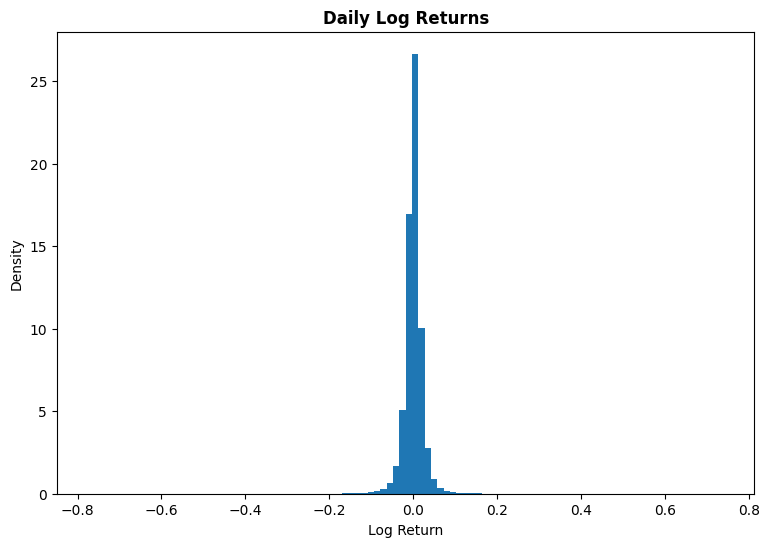

In [29]:
# Visualizing log returns
returns = feature_data_df['log_return_1d'].copy()

plt.figure(figsize=(9,6))
plt.hist(
    returns,
    bins = 100, 
    density = True
)
plt.title("Daily Log Returns", fontweight = 'bold')
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.show()

we observe that there is outliers in the daily log returns. Log return with ~ -13 means that the simple return is $\exp^{-13} \approx 0.000002$, which represents 99.9998% drop for a Fortune 500 stock. 

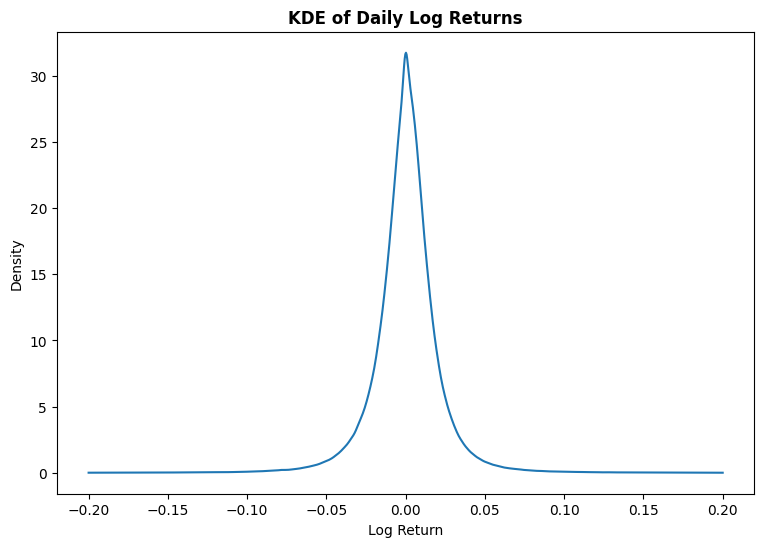

In [26]:
# Visualizing log returns
filtered_returns = returns[
    (returns > -0.2) & (returns < 0.2)
]

kde = gaussian_kde(filtered_returns)
x = np.linspace(-0.2, 0.2, 1000)

plt.figure(figsize=(9,6))
plt.plot(x, kde(x))
plt.title("KDE of Daily Log Returns", fontweight = 'bold')
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.show()

In [27]:
# Removing the outliers on 1d log returns in the feature dataset
feature_data_df = feature_data_df[
    feature_data_df['log_return_1d'].between(-1, 1)
]

for ticker, df in feature_data.items():
    df = df.copy()
    feature_data[ticker] = df[df['log_return_1d'].abs() < 1]

In [ ]:
# Visuaizing Normal vs. Empirical distribution of returns
x = np.linspace(returns.min(), returns.max(), 1000)

